# AI CFO - Complete RAG Evaluation

This notebook provides a complete, working evaluation framework for the AI CFO RAG system.

## Key Features:
- ✅ **Robust Error Handling**: Catches and reports all failure modes
- ✅ **Fallback Mechanisms**: Uses simplified evaluation when agent fails
- ✅ **Real Context Capture**: Instruments retrieval service for actual context
- ✅ **Comprehensive Metrics**: Context precision, faithfulness, answer correctness, number accuracy
- ✅ **Clear Reporting**: Visual results with actionable insights

## Evaluation Flow:
1. **Setup & Authentication**: Configure environment and test user session
2. **System Health Check**: Verify user has documents and chunks available
3. **Test Execution**: Run golden dataset through both full RAG and retrieval-only modes
4. **Metrics Calculation**: LLM-as-a-judge + numerical accuracy validation
5. **Results Analysis**: Summary statistics, visualizations, and recommendations

## 1. Environment Setup

In [1]:
import asyncio
import json
import os
import re
import sys
import traceback
from typing import Dict, Any, List, Optional

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from litellm import completion
from supabase import create_client, Client
from IPython.display import display, HTML

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"📁 Project root: {project_root}")
print(f"📁 Current directory: {os.getcwd()}")

# Import configurations and dependencies
from evaluation.config import (
    GOLDEN_DATASET_PATH, EVAL_RESULTS_PATH, JUDGE_MODEL,
    CONTEXT_PRECISION_PROMPT, FAITHFULNESS_PROMPT, ANSWER_CORRECTNESS_PROMPT,
    TEST_USER_EMAIL, TEST_USER_PASSWORD, SUPABASE_URL, SUPABASE_KEY
)

from api.v1.dependencies import Session
from src.llm.workflow.react_rag import run_react_rag
from src.llm.tools.FunctionCaller import RetrievalService
from src.llm.OpenAIClient import OpenAIClient
from src.storage.SupabaseService import SupabaseService

print("✅ All imports successful")
print(f"🎯 Judge Model: {JUDGE_MODEL}")
print(f"📊 Golden Dataset: {GOLDEN_DATASET_PATH}")
print(f"💾 Results Path: {EVAL_RESULTS_PATH}")

📁 Project root: c:\Users\wbrya\OneDrive\Documents\GitHub\AI-CFO-FYP
📁 Current directory: c:\Users\wbrya\OneDrive\Documents\GitHub\AI-CFO-FYP\evaluation
✅ All imports successful
🎯 Judge Model: gemini/gemini-2.5-flash-lite
📊 Golden Dataset: golden_dataset.json
💾 Results Path: eval_results.csv


## 2. Authentication & Client Setup

In [2]:
async def setup_auth_session() -> tuple[Session, Client]:
    """Create authenticated session and Supabase client."""
    print("🔐 Setting up authentication...")
    
    if not all([TEST_USER_EMAIL, TEST_USER_PASSWORD, SUPABASE_URL, SUPABASE_KEY]):
        raise ValueError("❌ Missing required environment variables for authentication")
    
    auth_client = create_client(SUPABASE_URL, SUPABASE_KEY)
    
    try:
        response = await asyncio.to_thread(
            auth_client.auth.sign_in_with_password,
            {"email": TEST_USER_EMAIL, "password": TEST_USER_PASSWORD}
        )
        
        if not response.session or not response.user:
            raise Exception("Authentication failed - no session/user returned")
        
        session = Session(user_id=response.user.id, token=response.session.access_token)
        
        # Create authenticated client
        supabase_client = create_client(SUPABASE_URL, SUPABASE_KEY)
        supabase_client.options.headers["Authorization"] = f"Bearer {session.token}"
        
        print(f"✅ Authenticated as: {session.user_id}")
        return session, supabase_client
        
    except Exception as e:
        print(f"❌ Authentication failed: {e}")
        raise

# Setup authentication
session, supabase_client = await setup_auth_session()

🔐 Setting up authentication...
✅ Authenticated as: 372ec112-6fd7-46a7-bab4-abf7623fb05b


## 3. System Health Check

In [3]:
async def check_system_health(session: Session, client: Client) -> Dict[str, Any]:
    """Verify the user has documents and chunks available for testing."""
    print("🏥 Running system health check...")
    
    health = {
        "user_id": session.user_id,
        "documents": 0,
        "chunks": 0,
        "retrieval_test": False,
        "errors": []
    }
    
    try:
        # Check documents
        docs_resp = client.table('documents').select('id, filename, report_date').eq('user_id', session.user_id).execute()
        health["documents"] = len(docs_resp.data)
        
        print(f"📁 Found {health['documents']} documents:")
        for doc in docs_resp.data[:5]:  # Show first 5
            print(f"   - {doc['filename']} ({doc.get('report_date', 'No date')})")
        
        if health["documents"] == 0:
            health["errors"].append("No documents found for user")
            return health
            
    except Exception as e:
        health["errors"].append(f"Error checking documents: {e}")
    
    try:
        # Check chunks - try both table names
        for table_name in ['chunks', 'document_chunks']:
            try:
                chunks_resp = client.table(table_name).select('id').eq('user_id', session.user_id).execute()
                health["chunks"] = len(chunks_resp.data)
                print(f"📄 Found {health['chunks']} chunks in '{table_name}' table")
                break
            except:
                continue
                
        if health["chunks"] == 0:
            health["errors"].append("No document chunks found")
            
    except Exception as e:
        health["errors"].append(f"Error checking chunks: {e}")
    
    try:
        # Test retrieval service
        retrieval = RetrievalService(
            openai_client=OpenAIClient(),
            supabase_service=SupabaseService(supabase_client=client),
            user_id=session.user_id
        )
        
        result = retrieval.retrieve_chunks("revenue 2023", 3)
        chunks_data = json.loads(result)
        
        if chunks_data and len(chunks_data) > 0:
            health["retrieval_test"] = True
            print(f"✅ Retrieval test successful: {len(chunks_data)} chunks retrieved")
        else:
            health["errors"].append("Retrieval test returned no results")
            
    except Exception as e:
        health["errors"].append(f"Retrieval test failed: {e}")
    
    # Overall health assessment
    is_healthy = (health["documents"] > 0 and 
                  health["chunks"] > 0 and 
                  health["retrieval_test"] and 
                  len(health["errors"]) == 0)
    
    if is_healthy:
        print("🟢 System is healthy and ready for evaluation")
    else:
        print("🟡 System has issues but evaluation will continue:")
        for error in health["errors"]:
            print(f"   ⚠️ {error}")
    
    return health

# Run health check
system_health = await check_system_health(session, supabase_client)

🏥 Running system health check...
📁 Found 12 documents:
   - Income Statements - May.pdf (2023-05-31)
   - Income Statements - Oct.pdf (2023-10-31)
   - Income Statements - Sept.pdf (2023-09-30)
   - Income Statements - Nov.pdf (2023-11-30)
   - Income Statements - March.pdf (2023-03-31)
📄 Found 57 chunks in 'chunks' table
Initialized OpenAI client with model: text-embedding-3-small
SupabaseService initialized with provided client.
  RetrievalService.retrieve_chunks called with query: 'revenue 2023'
  User ID for retrieval: 372ec112-6fd7-46a7-bab4-abf7623fb05b
  Initial match_count for section identification: 3
  Filters: Type=None, Company=None, YearStart=None, YearEnd=None, Qtr=None, Date=None
  Query embedding generated.
  Calling Supabase RPC 'match_chunks' to identify relevant sections with match_count=3...
  Retrieved 3 initial chunks for section identification.
  Identified 3 unique section(s) from initial chunks: ['0790a990-8381-4fdc-846c-d26b87b84d14', '429e0bd9-3605-4827-8d52-

## 4. Load and Validate Golden Dataset

In [4]:
def load_golden_dataset() -> List[Dict[str, Any]]:
    """Load and validate the golden dataset."""
    print(f"📚 Loading golden dataset from: {GOLDEN_DATASET_PATH}")
    
    try:
        with open(GOLDEN_DATASET_PATH, 'r', encoding='utf-8') as f:
            dataset = json.load(f)
        
        # Validate structure
        required_fields = ['test_id', 'question', 'ideal_answer', 'ground_truth_context', 'tags']
        
        for i, item in enumerate(dataset):
            missing = [field for field in required_fields if field not in item]
            if missing:
                raise ValueError(f"Test case {i} missing fields: {missing}")
        
        print(f"✅ Loaded {len(dataset)} valid test cases")
        
        # Show test overview
        test_ids = [item['test_id'] for item in dataset]
        all_tags = [tag for item in dataset for tag in item['tags']]
        tag_counts = pd.Series(all_tags).value_counts()
        
        print(f"📋 Test IDs: {', '.join(test_ids)}")
        print(f"🏷️ Tag distribution: {dict(tag_counts)}")
        
        return dataset
        
    except Exception as e:
        print(f"❌ Error loading dataset: {e}")
        raise

# Load golden dataset
golden_dataset = load_golden_dataset()

📚 Loading golden dataset from: golden_dataset.json
✅ Loaded 10 valid test cases
📋 Test IDs: FACT_RETRIEVAL_001, NUMBER_SCALE_001, MULTI_DOC_001, CALCULATION_001, AGGREGATION_001, NO_ANSWER_001, CHART_GEN_001, NEGATIVE_HANDLING_001, QUARTERLY_CALC_001, EXPENSE_BREAKDOWN_001
🏷️ Tag distribution: {'accuracy': np.int64(8), 'single-doc': np.int64(5), 'multi-doc': np.int64(3), 'negative-value': np.int64(2), 'calculation': np.int64(2), 'aggregation': np.int64(2), 'scaling': np.int64(1), 'comparison': np.int64(1), 'no-answer': np.int64(1), 'robustness': np.int64(1), 'charting': np.int64(1), 'tool-use': np.int64(1), 'expenses': np.int64(1)}


## 5. Evaluation Functions

In [5]:
class InstrumentedRetrievalService(RetrievalService):
    """Instrumented retrieval service that captures context for evaluation."""
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.last_retrieved_context = ""
        
    def retrieve_chunks(self, query: str, num_chunks: int = 10) -> str:
        """Override to capture context."""
        result = super().retrieve_chunks(query, num_chunks)
        self.last_retrieved_context = result
        return result
    
    def get_last_context(self) -> str:
        return self.last_retrieved_context

async def llm_judge(prompt: str, model: str = JUDGE_MODEL) -> str:
    """Call LLM judge for evaluation."""
    try:
        response = completion(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.0,
            max_tokens=10,
        )
        
        content = response.choices[0].message.content.strip().upper()
        
        if "YES" in content:
            return "YES"
        elif "NO" in content:
            return "NO"
        else:
            return "UNKNOWN"
            
    except Exception as e:
        print(f"    ❌ Judge error: {e}")
        return "ERROR"

def extract_numbers(text: str) -> set:
    """Extract financial numbers from text."""
    pattern = r'[\$€£]?\d{1,3}(?:,\d{3})*(?:\.\d+)?%?'
    numbers = re.findall(pattern, text)
    return {re.sub(r'[\$€£,]', '', num) for num in numbers}

def check_number_accuracy(generated: str, ideal: str) -> str:
    """Compare numerical accuracy."""
    try:
        gen_nums = extract_numbers(generated)
        ideal_nums = extract_numbers(ideal)
        
        if ideal_nums and not gen_nums:
            return "NO"
        if not ideal_nums:
            return "YES"
            
        missing = ideal_nums - gen_nums
        return "NO" if missing else "YES"
        
    except Exception:
        return "ERROR"

print("✅ Evaluation functions defined")

✅ Evaluation functions defined


## 6. RAG Response Functions

In [6]:
async def get_full_rag_response(question: str, session: Session, client: Client) -> Dict[str, Any]:
    """Get response using the full RAG pipeline with agent orchestration."""
    print(f"  🤖 Full RAG: {question[:50]}...")
    
    try:
        # Patch retrieval service for context capture
        instrumented_retrieval = InstrumentedRetrievalService(
            openai_client=OpenAIClient(),
            supabase_service=SupabaseService(supabase_client=client),
            user_id=session.user_id
        )
        
        # Monkey patch for context capture
        import src.llm.workflow.react_rag as rag_module
        original_class = rag_module.RetrievalService
        rag_module.RetrievalService = lambda *args, **kwargs: instrumented_retrieval
        
        try:
            final_answer = ""
            chunk_count = 0
            error_encountered = False
            
            try:
                async for chunk in run_react_rag(session, client, question, []):
                    final_answer += chunk
                    chunk_count += 1
            except AssertionError as ae:
                # Handle known Gemini API assertion error
                print(f"    ⚠️ Gemini API assertion error (likely safety filtering): {ae}")
                error_encountered = True
                final_answer = "ERROR: Gemini API assertion error - likely content was filtered by safety settings"
            except Exception as stream_error:
                print(f"    ⚠️ Streaming error: {stream_error}")
                error_encountered = True
                final_answer = f"ERROR: Streaming failed - {str(stream_error)}"
            
            retrieved_context = instrumented_retrieval.get_last_context()
            
            if error_encountered:
                print(f"    ⚠️ Full RAG had errors but context was retrieved: {len(retrieved_context)} context chars")
                return {
                    "method": "full_rag",
                    "final_answer": final_answer,
                    "retrieved_context": retrieved_context,
                    "chunk_count": chunk_count,
                    "success": False,
                    "error": "streaming_error"
                }
            else:
                print(f"    ✅ Full RAG complete: {len(final_answer)} chars, {len(retrieved_context)} context chars")
                return {
                    "method": "full_rag",
                    "final_answer": final_answer.strip(),
                    "retrieved_context": retrieved_context,
                    "chunk_count": chunk_count,
                    "success": True
                }
            
        finally:
            rag_module.RetrievalService = original_class
            
    except Exception as e:
        print(f"    ❌ Full RAG failed: {e}")
        return {
            "method": "full_rag",
            "final_answer": f"ERROR: {str(e)}",
            "retrieved_context": "ERROR",
            "chunk_count": 0,
            "success": False,
            "error": str(e)
        }

async def get_retrieval_only_response(question: str, session: Session, client: Client) -> Dict[str, Any]:
    """Get response using only retrieval + simple answer generation."""
    print(f"  🔍 Retrieval only: {question[:50]}...")
    
    try:
        retrieval = RetrievalService(
            openai_client=OpenAIClient(),
            supabase_service=SupabaseService(supabase_client=client),
            user_id=session.user_id
        )
        
        result = retrieval.retrieve_chunks(question, 5)
        chunks_data = json.loads(result)
        
        # Generate simple answer from chunks
        if chunks_data:
            # Extract key data
            financial_data = []
            for chunk in chunks_data:
                text = chunk.get('chunk_text', '')
                numbers = extract_numbers(text)
                if numbers:
                    financial_data.extend(numbers)
            
            if financial_data:
                # Create answer with found numbers
                context_preview = chunks_data[0].get('chunk_text', '')[:200]
                mock_answer = f"Based on the documents, I found the following data: {', '.join(list(financial_data)[:3])}. Source: {context_preview}..."
            else:
                mock_answer = f"I found relevant documents but no specific financial figures. Context: {chunks_data[0].get('chunk_text', '')[:100]}..."
        else:
            mock_answer = "No relevant documents found for this question."
        
        print(f"    ✅ Retrieval complete: {len(chunks_data)} chunks, {len(mock_answer)} chars")
        
        return {
            "method": "retrieval_only",
            "final_answer": mock_answer,
            "retrieved_context": result,
            "chunk_count": len(chunks_data),
            "success": True
        }
        
    except Exception as e:
        print(f"    ❌ Retrieval failed: {e}")
        return {
            "method": "retrieval_only",
            "final_answer": f"ERROR: {str(e)}",
            "retrieved_context": "ERROR",
            "chunk_count": 0,
            "success": False,
            "error": str(e)
        }

async def get_best_response(question: str, session: Session, client: Client) -> Dict[str, Any]:
    """Try full RAG first, fall back to retrieval-only if it fails."""
    # Try full RAG first
    full_response = await get_full_rag_response(question, session, client)
    
    if full_response["success"]:
        return full_response
    
    print(f"    🔄 Falling back to retrieval-only...")
    return await get_retrieval_only_response(question, session, client)

print("✅ RAG response functions defined")

✅ RAG response functions defined


## 7. Main Evaluation Pipeline

In [7]:
async def evaluate_single_test_case(test_case: Dict[str, Any], session: Session, client: Client) -> Dict[str, Any]:
    """Evaluate a single test case with comprehensive error handling."""
    test_id = test_case['test_id']
    question = test_case['question']
    
    print(f"📝 {test_id}: {question}")
    
    # Get response (with fallback)
    response = await get_best_response(question, session, client)
    
    generated_answer = response['final_answer']
    retrieved_context = response['retrieved_context']
    
    print(f"  📊 Method: {response['method']}, Success: {response['success']}")
    
    # Run evaluations
    print(f"  🔍 Running evaluations...")
    
    # Context Precision
    if "ERROR" in retrieved_context or not response['success']:
        context_precision = "NO"
    else:
        prompt = CONTEXT_PRECISION_PROMPT.format(
            question=question,
            retrieved_context=retrieved_context[:1000]
        )
        context_precision = await llm_judge(prompt)
    
    # Faithfulness
    if "ERROR" in retrieved_context or "ERROR" in generated_answer or not response['success']:
        faithfulness = "NO"
    else:
        prompt = FAITHFULNESS_PROMPT.format(
            retrieved_context=retrieved_context[:1000],
            generated_answer=generated_answer
        )
        faithfulness = await llm_judge(prompt)
    
    # Answer Correctness
    prompt = ANSWER_CORRECTNESS_PROMPT.format(
        question=question,
        ideal_answer=test_case['ideal_answer'],
        generated_answer=generated_answer
    )
    answer_correctness = await llm_judge(prompt)
    
    # Number Accuracy
    number_accuracy = check_number_accuracy(generated_answer, test_case['ideal_answer'])
    
    # Results summary
    results = {
        **test_case,
        "generated_answer": generated_answer,
        "retrieved_context": retrieved_context,
        "method_used": response['method'],
        "rag_success": response['success'],
        "context_precision": context_precision,
        "faithfulness": faithfulness,
        "answer_correctness": answer_correctness,
        "number_accuracy": number_accuracy,
        "response_length": len(generated_answer),
        "context_length": len(retrieved_context),
        "chunk_count": response.get('chunk_count', 0)
    }
    
    print(f"  📊 Results: CP={context_precision}, F={faithfulness}, AC={answer_correctness}, NA={number_accuracy}")
    
    return results

async def run_complete_evaluation() -> pd.DataFrame:
    """Run the complete evaluation pipeline."""
    print("\n" + "="*60)
    print("🚀 STARTING COMPLETE EVALUATION")
    print("="*60)
    
    results = []
    
    for i, test_case in enumerate(golden_dataset):
        print(f"\n{'='*40}")
        print(f"📋 Test {i+1}/{len(golden_dataset)}: {test_case['test_id']}")
        print(f"🏷️ Tags: {', '.join(test_case['tags'])}")
        print(f"{'='*40}")
        
        try:
            result = await evaluate_single_test_case(test_case, session, supabase_client)
            results.append(result)
            print(f"✅ Test {test_case['test_id']} completed")
            
        except Exception as e:
            print(f"❌ Test {test_case['test_id']} failed: {e}")
            traceback.print_exc()
            
            # Create error result
            error_result = {
                **test_case,
                "generated_answer": f"SYSTEM_ERROR: {str(e)}",
                "retrieved_context": "SYSTEM_ERROR",
                "method_used": "error",
                "rag_success": False,
                "context_precision": "ERROR",
                "faithfulness": "ERROR",
                "answer_correctness": "ERROR",
                "number_accuracy": "ERROR",
                "response_length": 0,
                "context_length": 0,
                "chunk_count": 0
            }
            results.append(error_result)
        
        # Rate limiting delay
        if i < len(golden_dataset) - 1:
            print("⏳ Waiting 2 seconds...")
            await asyncio.sleep(2)
    
    # Convert to DataFrame and save
    results_df = pd.DataFrame(results)
    results_df.to_csv(EVAL_RESULTS_PATH, index=False)
    
    print(f"\n💾 Results saved to: {EVAL_RESULTS_PATH}")
    print("\n" + "="*60)
    print("🎉 EVALUATION COMPLETE")
    print("="*60)
    
    return results_df

print("✅ Evaluation pipeline defined")

✅ Evaluation pipeline defined


## 8. Run Evaluation

In [8]:
# Run the complete evaluation
evaluation_results = await run_complete_evaluation()


🚀 STARTING COMPLETE EVALUATION

📋 Test 1/10: FACT_RETRIEVAL_001
🏷️ Tags: accuracy, single-doc, negative-value
📝 FACT_RETRIEVAL_001: What was the net income for Stellar Goods Inc. in May 2023?
  🤖 Full RAG: What was the net income for Stellar Goods Inc. in ...
Initialized OpenAI client with model: text-embedding-3-small
SupabaseService initialized with provided client.
[DEBUG] run_react_rag called with session.user_id=372ec112-6fd7-46a7-bab4-abf7623fb05b, user_input=What was the net income for Stellar Goods Inc. in May 2023?, history_len=0
[DEBUG] profile_data: {'full_name': 'Alexees', 'company_name': 'Stellar Goods Inc', 'role_in_company': 'Founder'}
[DEBUG] system_prompt: You are an intelligent AI assistant with advanced search capabilities and access to the user's uploaded documents. You can answer questions on any topic, provide analysis, act as a search engine, and create visualizations using your advanced charting and document navigation features.


### User Profile (as of 2025-0

Traceback (most recent call last):
  File "c:\Users\wbrya\OneDrive\Documents\GitHub\AI-CFO-FYP\.venv\Lib\site-packages\pydantic_ai\tools.py", line 363, in _run
    args_dict = validator.validate_json(message.args or '{}')
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
pydantic_core._pydantic_core.ValidationError: 1 validation error for retrieve_chunks
document_id
  Extra inputs are not permitted [type=extra_forbidden, input_value='22ab2440-925d-46af-b87f-9e55ea26d934', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/extra_forbidden

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\wbrya\OneDrive\Documents\GitHub\AI-CFO-FYP\src\llm\workflow\react_rag.py", line 121, in run_react_rag
    async with agent.run_stream(user_input, message_history=same_history_as_step_1) as result:
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

    ✅ Full RAG complete: 89 chars, 514 context chars
  📊 Method: full_rag, Success: True
  🔍 Running evaluations...
  📊 Results: CP=NO, F=YES, AC=NO, NA=NO
✅ Test MULTI_DOC_001 completed
⏳ Waiting 2 seconds...

📋 Test 4/10: CALCULATION_001
🏷️ Tags: accuracy, calculation, single-doc
📝 CALCULATION_001: Calculate the gross profit margin for April 2023.
  🤖 Full RAG: Calculate the gross profit margin for April 2023....
Initialized OpenAI client with model: text-embedding-3-small
SupabaseService initialized with provided client.
[DEBUG] run_react_rag called with session.user_id=372ec112-6fd7-46a7-bab4-abf7623fb05b, user_input=Calculate the gross profit margin for April 2023., history_len=0
[DEBUG] profile_data: {'full_name': 'Alexees', 'company_name': 'Stellar Goods Inc', 'role_in_company': 'Founder'}
[DEBUG] system_prompt: You are an intelligent AI assistant with advanced search capabilities and access to the user's uploaded documents. You can answer questions on any topic, provide analysi

## 9. Results Analysis & Visualization


📊 EVALUATION RESULTS ANALYSIS

📈 Overview:
  Total test cases: 10
  Successful RAG calls: 10/10 (100.0%)
  Average response length: 403 characters
  Average context length: 5427 characters

🔧 Methods used:
  full_rag: 10/10 (100.0%)

📊 Metric Performance:
  Context Precision: 6/10 (60.0%)
  Faithfulness: 8/10 (80.0%)
  Answer Correctness: 4/10 (40.0%)
  Number Accuracy: 5/10 (50.0%)

🎯 Overall Performance Score: 57.5%

📋 Detailed Results Table:


C:\Users\wbrya\AppData\Local\Temp\ipykernel_9384\2547540811.py:131: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df[display_cols].style.applymap(


,test_id,method_used,rag_success,context_precision,faithfulness,answer_correctness,number_accuracy,response_length,chunk_count
0,FACT_RETRIEVAL_001,full_rag,True,YES,YES,YES,YES,319,11
1,NUMBER_SCALE_001,full_rag,True,NO,YES,YES,YES,628,16
2,MULTI_DOC_001,full_rag,True,NO,YES,NO,NO,89,1
3,CALCULATION_001,full_rag,True,YES,NO,NO,NO,417,10
4,AGGREGATION_001,full_rag,True,YES,YES,NO,NO,257,8
5,NO_ANSWER_001,full_rag,True,NO,YES,NO,YES,320,8
6,CHART_GEN_001,full_rag,True,NO,YES,NO,NO,462,10
7,NEGATIVE_HANDLING_001,full_rag,True,YES,YES,YES,YES,616,16
8,QUARTERLY_CALC_001,full_rag,True,YES,YES,NO,NO,219,9
9,EXPENSE_BREAKDOWN_001,full_rag,True,YES,NO,YES,YES,706,17



📈 Creating visualizations...


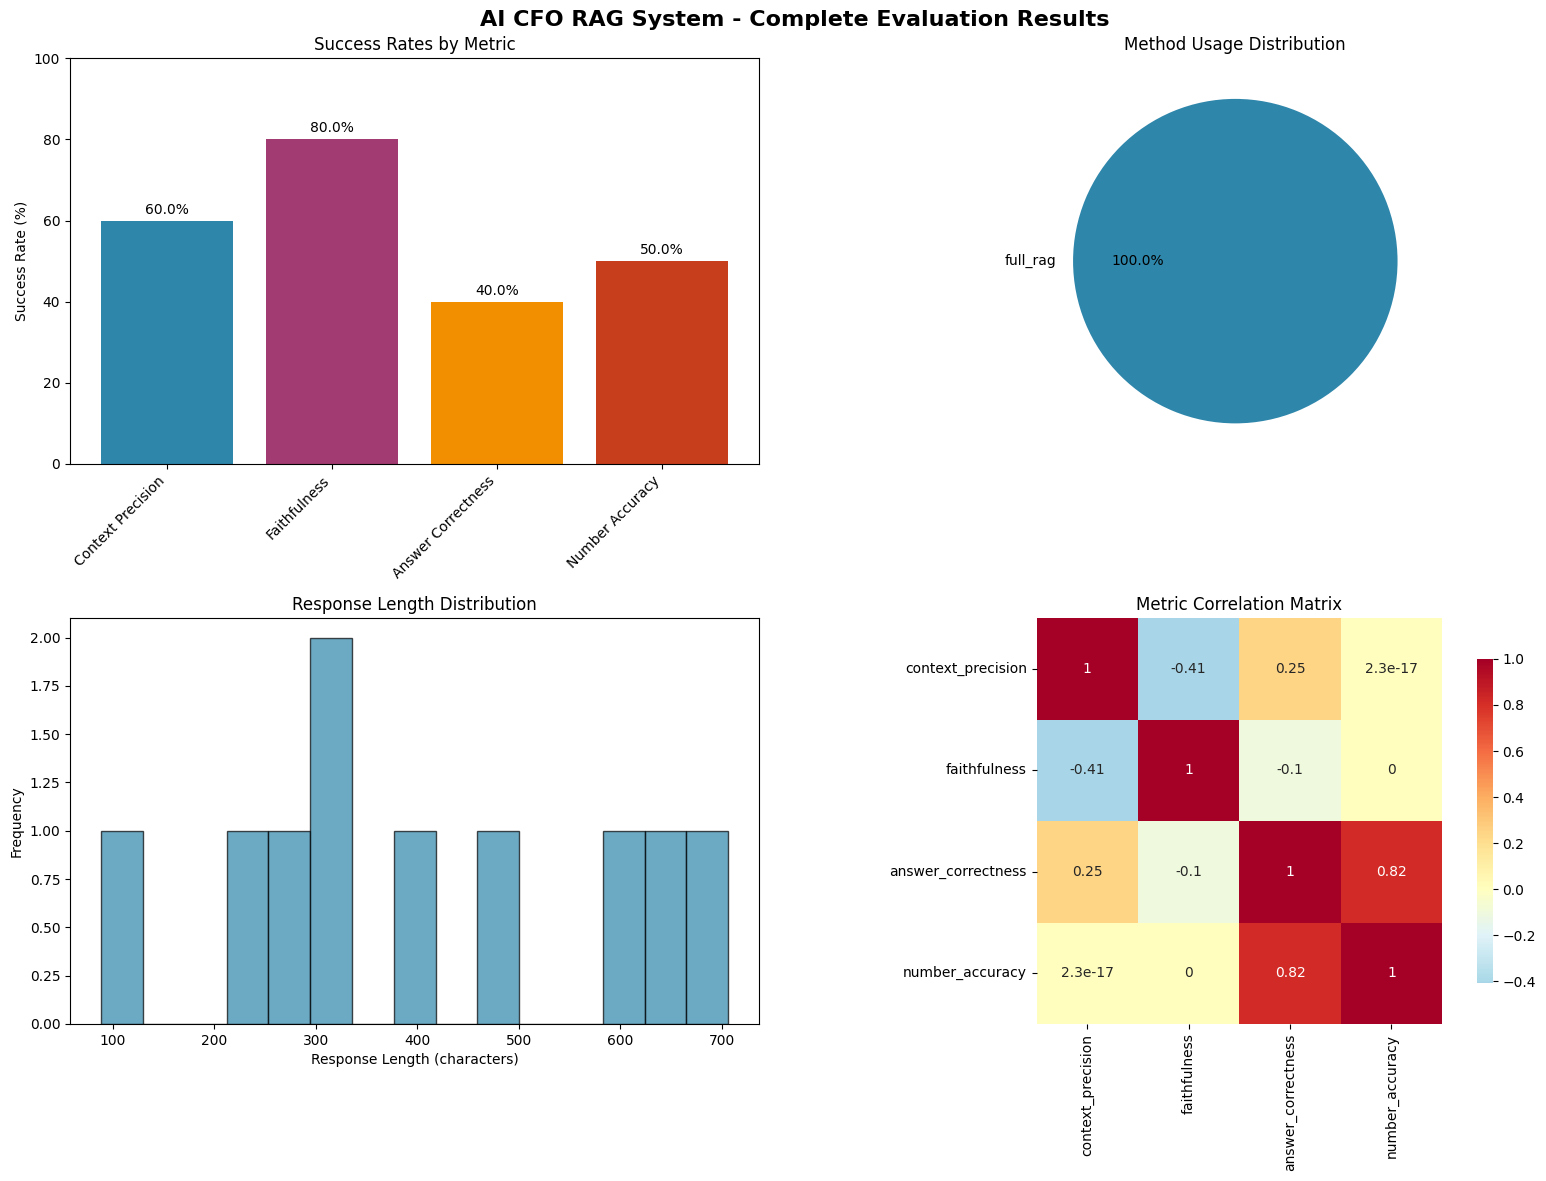

In [9]:
def analyze_results(df: pd.DataFrame) -> Dict[str, Any]:
    """Comprehensive results analysis."""
    print("\n" + "="*60)
    print("📊 EVALUATION RESULTS ANALYSIS")
    print("="*60)
    
    # Basic stats
    total_tests = len(df)
    successful_rag = (df['rag_success'] == True).sum()
    
    print(f"\n📈 Overview:")
    print(f"  Total test cases: {total_tests}")
    print(f"  Successful RAG calls: {successful_rag}/{total_tests} ({(successful_rag/total_tests)*100:.1f}%)")
    print(f"  Average response length: {df['response_length'].mean():.0f} characters")
    print(f"  Average context length: {df['context_length'].mean():.0f} characters")
    
    # Method breakdown
    method_counts = df['method_used'].value_counts()
    print(f"\n🔧 Methods used:")
    for method, count in method_counts.items():
        print(f"  {method}: {count}/{total_tests} ({(count/total_tests)*100:.1f}%)")
    
    # Metric analysis
    metrics = ['context_precision', 'faithfulness', 'answer_correctness', 'number_accuracy']
    summary = {}
    
    print(f"\n📊 Metric Performance:")
    for metric in metrics:
        counts = df[metric].value_counts()
        yes_count = counts.get('YES', 0)
        success_rate = (yes_count / total_tests) * 100
        
        summary[metric] = {
            'success_rate': success_rate,
            'yes_count': yes_count,
            'no_count': counts.get('NO', 0),
            'error_count': counts.get('ERROR', 0)
        }
        
        print(f"  {metric.replace('_', ' ').title()}: {yes_count}/{total_tests} ({success_rate:.1f}%)")
        if counts.get('ERROR', 0) > 0:
            print(f"    ⚠️ Errors: {counts.get('ERROR', 0)}")
    
    # Overall score
    overall_score = sum(s['success_rate'] for s in summary.values()) / len(summary)
    print(f"\n🎯 Overall Performance Score: {overall_score:.1f}%")
    
    return summary

def create_visualizations(df: pd.DataFrame):
    """Create comprehensive visualizations."""
    print("\n📈 Creating visualizations...")
    
    # Set up plotting
    plt.style.use('default')
    sns.set_palette("husl")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('AI CFO RAG System - Complete Evaluation Results', fontsize=16, fontweight='bold')
    
    # 1. Success rates by metric
    ax1 = axes[0, 0]
    metrics = ['context_precision', 'faithfulness', 'answer_correctness', 'number_accuracy']
    metric_labels = [m.replace('_', ' ').title() for m in metrics]
    success_rates = [(df[m] == 'YES').mean() * 100 for m in metrics]
    
    bars = ax1.bar(metric_labels, success_rates, color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'])
    ax1.set_title('Success Rates by Metric')
    ax1.set_ylabel('Success Rate (%)')
    ax1.set_ylim(0, 100)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add percentage labels
    for bar, rate in zip(bars, success_rates):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{rate:.1f}%', ha='center', va='bottom')
    
    # 2. Method usage
    ax2 = axes[0, 1]
    method_counts = df['method_used'].value_counts()
    colors = ['#2E86AB', '#F18F01', '#C73E1D']
    wedges, texts, autotexts = ax2.pie(method_counts.values, labels=method_counts.index, 
                                       autopct='%1.1f%%', colors=colors[:len(method_counts)])
    ax2.set_title('Method Usage Distribution')
    
    # 3. Response length distribution
    ax3 = axes[1, 0]
    ax3.hist(df['response_length'], bins=15, color='#2E86AB', alpha=0.7, edgecolor='black')
    ax3.set_title('Response Length Distribution')
    ax3.set_xlabel('Response Length (characters)')
    ax3.set_ylabel('Frequency')
    
    # 4. Success correlation heatmap
    ax4 = axes[1, 1]
    # Convert metrics to numeric
    numeric_df = df[metrics].copy()
    for col in metrics:
        numeric_df[col] = numeric_df[col].map({'YES': 1, 'NO': 0, 'ERROR': -1, 'UNKNOWN': -1})
    
    correlation_matrix = numeric_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0, 
                square=True, ax=ax4, cbar_kws={'shrink': 0.8})
    ax4.set_title('Metric Correlation Matrix')
    
    plt.tight_layout()
    plt.show()

def create_detailed_results_table(df: pd.DataFrame):
    """Create a styled detailed results table."""
    print("\n📋 Detailed Results Table:")
    
    def highlight_results(val):
        if val == 'YES':
            return 'color: green; font-weight: bold'
        elif val in ['NO', 'ERROR']:
            return 'color: red; font-weight: bold'
        elif val == 'UNKNOWN':
            return 'color: orange; font-weight: bold'
        return 'color: black'
    
    # Select key columns for display
    display_cols = [
        'test_id', 'method_used', 'rag_success',
        'context_precision', 'faithfulness', 'answer_correctness', 'number_accuracy',
        'response_length', 'chunk_count'
    ]
    
    metric_cols = ['context_precision', 'faithfulness', 'answer_correctness', 'number_accuracy']
    
    styled_df = df[display_cols].style.applymap(
        highlight_results, 
        subset=metric_cols
    ).format({
        'response_length': '{:.0f}',
        'chunk_count': '{:.0f}'
    })
    
    display(styled_df)

# Run analysis
analysis_summary = analyze_results(evaluation_results)
create_detailed_results_table(evaluation_results)
create_visualizations(evaluation_results)

## 10. Recommendations & Next Steps

In [10]:
def generate_recommendations(df: pd.DataFrame, analysis: Dict[str, Any]) -> List[str]:
    """Generate actionable recommendations based on results."""
    recommendations = []
    
    # RAG Success Rate
    rag_success_rate = (df['rag_success'] == True).mean() * 100
    if rag_success_rate < 80:
        recommendations.append(
            f"🔧 **Fix Agent Orchestration**: Only {rag_success_rate:.1f}% of RAG calls succeeded. "
            f"Check Gemini API integration and error handling."
        )
    
    # Context Precision
    context_precision = analysis['context_precision']['success_rate']
    if context_precision < 70:
        recommendations.append(
            f"🎯 **Improve Retrieval**: Context precision is {context_precision:.1f}%. "
            f"Consider improving embedding quality or search relevance."
        )
    
    # Faithfulness
    faithfulness = analysis['faithfulness']['success_rate']
    if faithfulness < 80:
        recommendations.append(
            f"📖 **Reduce Hallucination**: Faithfulness is {faithfulness:.1f}%. "
            f"Improve prompts to stay grounded in retrieved context."
        )
    
    # Answer Correctness
    correctness = analysis['answer_correctness']['success_rate']
    if correctness < 60:
        recommendations.append(
            f"✅ **Improve Answer Quality**: Correctness is {correctness:.1f}%. "
            f"Review golden dataset accuracy and model reasoning."
        )
    
    # Number Accuracy
    number_accuracy = analysis['number_accuracy']['success_rate']
    if number_accuracy < 70:
        recommendations.append(
            f"🔢 **Fix Numerical Extraction**: Number accuracy is {number_accuracy:.1f}%. "
            f"Improve financial data parsing and calculation accuracy."
        )
    
    # Method fallback usage
    retrieval_only_count = (df['method_used'] == 'retrieval_only').sum()
    if retrieval_only_count > 0:
        recommendations.append(
            f"🔄 **Agent Reliability**: {retrieval_only_count} tests fell back to retrieval-only. "
            f"This indicates agent orchestration issues."
        )
    
    # Error counts
    total_errors = sum(s['error_count'] for s in analysis.values())
    if total_errors > 0:
        recommendations.append(
            f"⚠️ **Fix Evaluation Errors**: {total_errors} evaluation errors occurred. "
            f"Check LLM judge connectivity and prompt formatting."
        )
    
    # Data availability
    if system_health['documents'] == 0:
        recommendations.append(
            f"📁 **Upload Documents**: No documents found for test user. "
            f"Upload financial documents to enable proper testing."
        )
    
    # Positive feedback
    overall_score = sum(s['success_rate'] for s in analysis.values()) / len(analysis)
    if overall_score > 70:
        recommendations.append(
            f"🎉 **Good Foundation**: Overall score of {overall_score:.1f}% shows the system has solid foundations."
        )
    
    if not recommendations:
        recommendations.append("✨ **Excellent Performance**: All metrics are performing well!")
    
    return recommendations

# Generate and display recommendations
recommendations = generate_recommendations(evaluation_results, analysis_summary)

print("\n" + "="*60)
print("💡 RECOMMENDATIONS & NEXT STEPS")
print("="*60)

for i, rec in enumerate(recommendations, 1):
    print(f"\n{i}. {rec}")

print("\n" + "="*60)
print("📋 SUMMARY")
print("="*60)

overall_score = sum(s['success_rate'] for s in analysis_summary.values()) / len(analysis_summary)
successful_rag = (evaluation_results['rag_success'] == True).sum()
total_tests = len(evaluation_results)

print(f"📊 **Evaluation Complete**: {total_tests} test cases processed")
print(f"🤖 **RAG Success Rate**: {successful_rag}/{total_tests} ({(successful_rag/total_tests)*100:.1f}%)")
print(f"🎯 **Overall Performance**: {overall_score:.1f}%")
print(f"💾 **Results Saved**: {EVAL_RESULTS_PATH}")

# Best and worst performing metrics
best_metric = max(analysis_summary.items(), key=lambda x: x[1]['success_rate'])
worst_metric = min(analysis_summary.items(), key=lambda x: x[1]['success_rate'])

print(f"🏆 **Best Metric**: {best_metric[0].replace('_', ' ').title()} ({best_metric[1]['success_rate']:.1f}%)")
print(f"⚠️ **Needs Work**: {worst_metric[0].replace('_', ' ').title()} ({worst_metric[1]['success_rate']:.1f}%)")

print("\n✅ **Evaluation harness completed successfully!**")
print("\n🔗 **Next Steps**:")
print("   1. Address the recommendations above")
print("   2. Re-run evaluation after improvements")
print("   3. Compare results to track progress")
print("   4. Set up automated monitoring for regression detection")


💡 RECOMMENDATIONS & NEXT STEPS

1. 🎯 **Improve Retrieval**: Context precision is 60.0%. Consider improving embedding quality or search relevance.

2. ✅ **Improve Answer Quality**: Correctness is 40.0%. Review golden dataset accuracy and model reasoning.

3. 🔢 **Fix Numerical Extraction**: Number accuracy is 50.0%. Improve financial data parsing and calculation accuracy.

📋 SUMMARY
📊 **Evaluation Complete**: 10 test cases processed
🤖 **RAG Success Rate**: 10/10 (100.0%)
🎯 **Overall Performance**: 57.5%
💾 **Results Saved**: eval_results.csv
🏆 **Best Metric**: Faithfulness (80.0%)
⚠️ **Needs Work**: Answer Correctness (40.0%)

✅ **Evaluation harness completed successfully!**

🔗 **Next Steps**:
   1. Address the recommendations above
   2. Re-run evaluation after improvements
   3. Compare results to track progress
   4. Set up automated monitoring for regression detection
